In [2]:
import numpy as np
import pandas as pd
import scipy as stats

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix 

from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import resample
from pandas import Categorical, get_dummies


from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


%matplotlib inline
matplotlib.style.use('ggplot')

In [18]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        data = X.copy()
        return data.drop(labels=self.columns, axis='columns')
 
    

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """One hot encoder para colunas do tipo categorical"""
    def __init__(self, attribute_names):
        #list of column names with categorical variables
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        cats = {}
        for column in self.attribute_names:
            cats[column] = X[column].unique().tolist()
        self.categoricals = cats
        return self

    def transform(self, X, y=None):
        df = X.copy()
        for column in self.attribute_names:
            df[column] = Categorical(df[column], categories=self.categoricals[column])
        new_df = get_dummies(df, drop_first=False)
        self.columns = new_df.columns
        return new_df



In [4]:
csvfile = pd.read_csv('train_dataset_algartech.csv')
csvfile.head()

,Idade,Local de trabalho,Pontuação teste,Departmento,Distancia casa-trabalho,Educacao,Area,Possui carro,Subordinado,Satisfação com o ambiente no emprego atual,...,Horas de trabalho padrão,Beneficios,Anos de experiencia,Horas de treinamento ultimo ano,Estilo de vida,Anos na última empresa,Anos na posição atual,Anos desde última promoção,Anos com a mesma gerência,Contratar
0,49,Cliente,279,Engenharia,8,Médio completo,Ciências das natureza,1,2,3,...,80,1,10,3,3,10,7,1,7,Não
1,33,Misto,1392,Engenharia,3,Superior incompleto - cursando,Ciências das natureza,1,5,4,...,80,0,8,3,3,8,7,3,0,Não
2,27,Cliente,591,Engenharia,2,Médio completo,Medicina,1,7,1,...,80,1,6,3,3,2,2,2,2,Não
3,32,Misto,1005,Engenharia,2,Superior incompleto,Ciências das natureza,1,8,4,...,80,0,8,2,2,7,7,3,6,Não
4,59,Misto,1324,Engenharia,3,Superior completo,Medicina,1,10,3,...,80,3,12,3,2,1,0,0,0,Não


/home/marcosoliveira/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marcosoliveira/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Idade', ylabel='Density'>

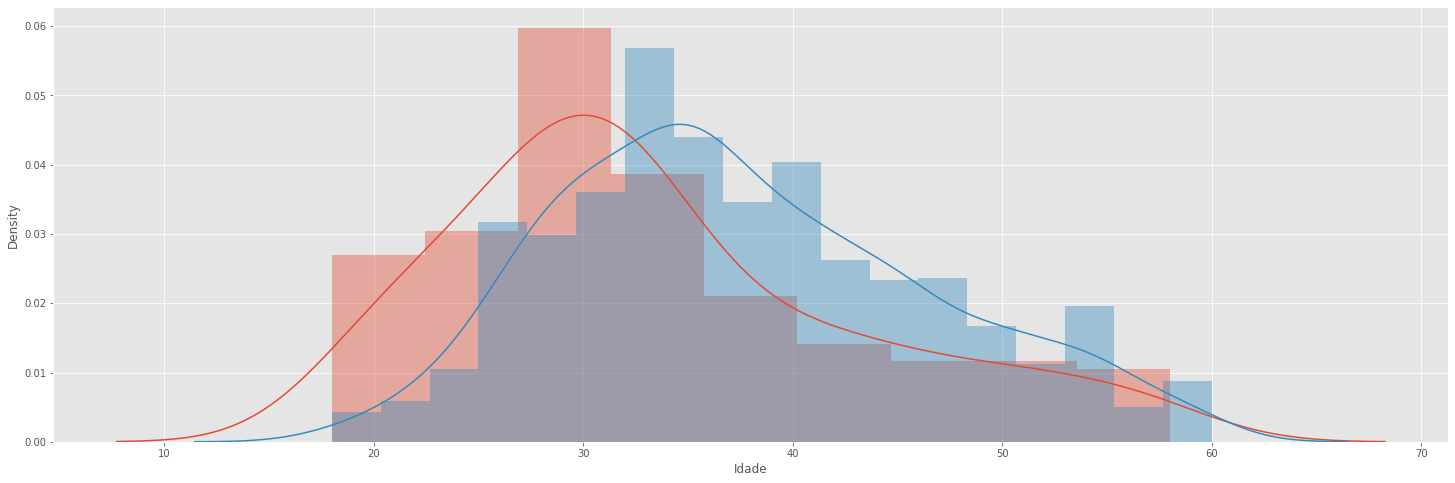

In [5]:
plt.figure(figsize=(25,8))
sns.distplot(csvfile[csvfile['Contratar']== 'Sim']['Idade'])
sns.distplot(csvfile[csvfile['Contratar']== 'Não']['Idade'])
#Proporção de contratação/não contratação por idade.

/home/marcosoliveira/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marcosoliveira/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Pontuação teste', ylabel='Density'>

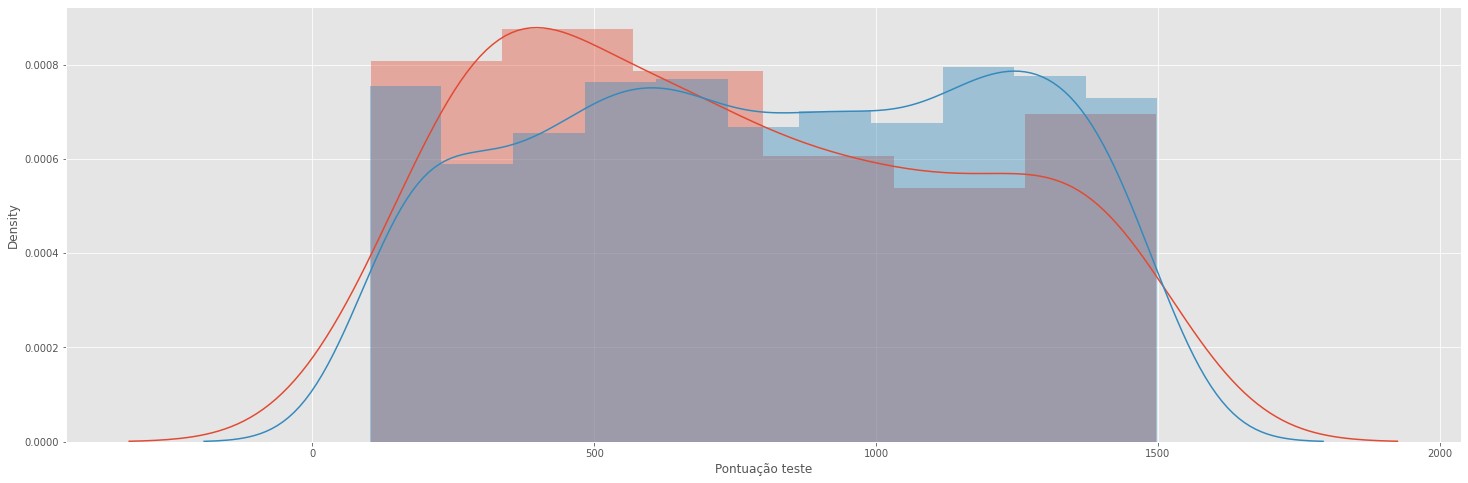

In [6]:
plt.figure(figsize=(25,8))
sns.distplot(csvfile[csvfile['Contratar']== 'Sim']['Pontuação teste'])
sns.distplot(csvfile[csvfile['Contratar']== 'Não']['Pontuação teste'])

/home/marcosoliveira/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marcosoliveira/.local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Performance na entrevista', ylabel='Density'>

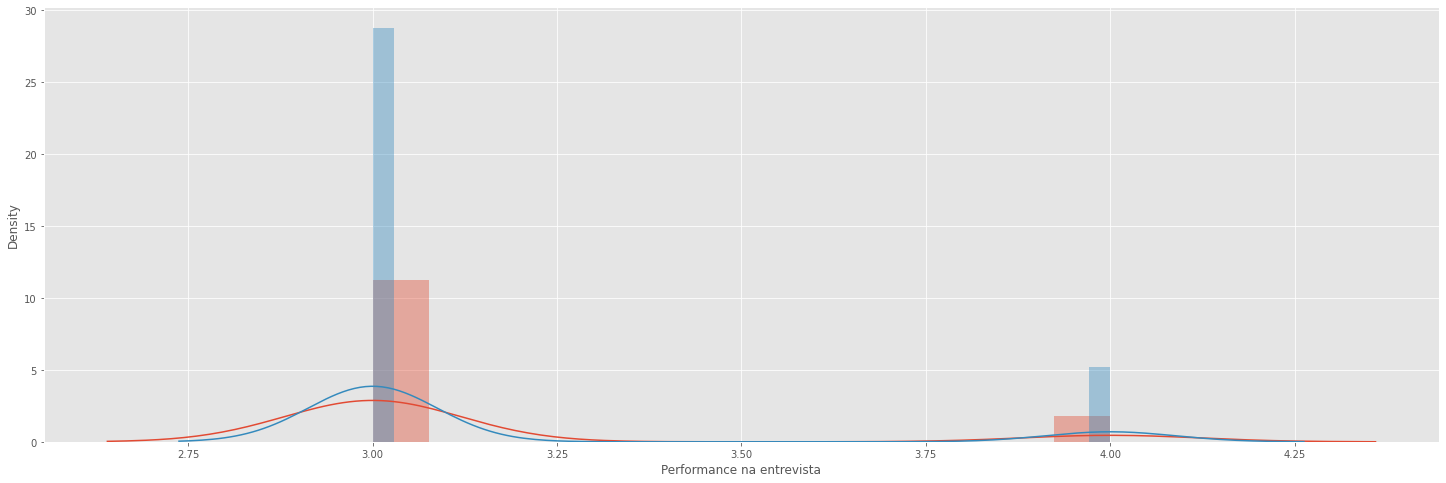

In [7]:
plt.figure(figsize=(25,8))
sns.distplot(csvfile[csvfile['Contratar']== 'Sim']['Performance na entrevista'])
sns.distplot(csvfile[csvfile['Contratar']== 'Não']['Performance na entrevista'])


In [8]:
print(csvfile['Contratar'].value_counts())


Não    1178
Sim     192
Name: Contratar, dtype: int64


In [28]:
features = ['Idade',
           'Local de trabalho',
           'Pontuação teste',
           'Departmento',
           'Distancia casa-trabalho',
           'Educacao',
           'Area',
           'Possui carro',
           'Subordinado',
           'Satisfação com o ambiente no emprego atual',
           'Genero',
           'Horas voluntariado',
           'Envolvimento com trabalho',
           'Posicao',
           'Cargo',
           'Satisfação com emprego',
           'Estado civil',
           'Renda',
           'Bonus de performance',
           'Quantidade de empresas que trabalho',
           'Maior de idade',
           'Necessita de hora extra',
           'Aumento de salario%',
           'Performance na entrevista',
           'Satisfação com a relação',
           'Horas de trabalho padrão',
           'Beneficios',
           'Anos de experiencia',
           'Horas de treinamento ultimo ano',
           'Estilo de vida',
           'Anos na última empresa',
           'Anos na posição atual',
           'Anos desde última promoção',
           'Anos com a mesma gerência']

datafeatures = csvfile[features]
datatarget = csvfile['Contratar']


In [29]:
#Creating a new dataset preprocessed for test
res = CategoricalEncoder(['Departmento','Educacao','Area','Local de trabalho','Departmento','Educacao','Area','Genero','Cargo','Estado civil','Necessita de hora extra'])
res.fit(datafeatures)
df_data_1 = pd.DataFrame.from_records(
    data=res.transform(
        X=datafeatures
    ),  
)

scaler = preprocessing.StandardScaler()
df_data_2 = pd.DataFrame(scaler.fit_transform(df_data_1),columns=df_data_1.columns)


sm = SMOTE(random_state=2)
X_res, y_res = sm.fit_resample(df_data_2, datatarget)



newdataset = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
newdataset.columns = pd.concat([pd.DataFrame(df_data_2), pd.DataFrame(datatarget)], axis=1).columns




datatarget = newdataset['Contratar']

newdataset.head()

,Idade,Pontuação teste,Distancia casa-trabalho,Possui carro,Subordinado,Satisfação com o ambiente no emprego atual,Horas voluntariado,Envolvimento com trabalho,Posicao,Satisfação com emprego,...,Cargo_Diretor,Cargo_Vendedo senior,Cargo_Vendedor junior,Cargo_Assistente,Estado civil_Casado,Estado civil_Solteiro,Estado civil_Divorciado,Necessita de hora extra_Não,Necessita de hora extra_Sim,Contratar
0,1.301982,-1.306730,-0.138320,0.0,-1.773228,0.247441,-0.235855,-1.056060,-0.073414,-0.653189,...,-0.242348,-0.535149,-0.235521,-0.192596,1.090183,-0.675202,-0.546423,0.617291,-0.617291,Não
1,-0.438440,1.446496,-0.764138,0.0,-1.767963,1.163641,-0.481164,0.359598,-0.971429,0.249807,...,-0.242348,-0.535149,-0.235521,-0.192596,1.090183,-0.675202,-0.546423,-1.619981,1.619981,Não
2,-1.091099,-0.534936,-0.889301,0.0,-1.764452,-1.584960,-1.266152,0.359598,-0.971429,-0.653189,...,-0.242348,-0.535149,-0.235521,-0.192596,1.090183,-0.675202,-0.546423,0.617291,-0.617291,Não
3,-0.547217,0.489175,-0.889301,0.0,-1.762697,1.163641,0.647258,0.359598,-0.971429,1.152803,...,-0.242348,-0.535149,-0.235521,-0.192596,-0.917277,1.481038,-0.546423,0.617291,-0.617291,Não
4,2.389746,1.278284,-0.764138,0.0,-1.759187,0.247441,0.745381,1.775256,-0.971429,-1.556185,...,-0.242348,-0.535149,-0.235521,-0.192596,1.090183,-0.675202,-0.546423,-1.619981,1.619981,Não


In [22]:
dropcolumn = DropColumns(columns=["Contratar"])
dropcolumn.fit(X=newdataset)
datafeature = pd.DataFrame.from_records(
    data=dropcolumn.transform(
        X=newdataset       
    ),
)

X_train, X_test, y_train, y_test = train_test_split(datafeature, datatarget, test_size=0.3, random_state=337)

In [23]:
estimators =1000
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=337,n_estimators=estimators)


In [13]:
#Finding optimum features 

rfe = RFECV(estimator=xgb_model)
rfe.fit(X_train, y_train)

RFECV(estimator=XGBClassifier(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, gamma=None, gpu_id=None,
                              importance_type='gain',
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=1000,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=337, reg_alpha=None, reg_lambda=None,
                              scale_pos_weight=None, subsample=None,
                              tree_method=None, validate_parameters=None,
                              verbosity=None))

In [14]:
columns = pd.DataFrame({'coluna':X_train.columns,
              'bool': rfe.support_})
final_features = columns.query('bool == True')
unusedfeatures = columns.query('bool == False')

In [24]:
new_data_features = datafeature[final_features.coluna.values]
new_data_features.head()
X_train, X_test, y_train, y_test = train_test_split(new_data_features, datatarget, test_size=0.3, random_state=337)

In [25]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=337,n_estimators=estimators)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_train)
print("Acuracy for train: {}%".format(100*round(accuracy_score(y_train, xgb_pred), 10)))
print(confusion_matrix(y_train, xgb_pred))

xgb_pred = xgb_model.predict(X_test)
print("Acuracy for test: {}%".format(100*round(accuracy_score(y_test, xgb_pred), 10)))
print(confusion_matrix(y_test, xgb_pred))


Acuracy for train: 100.0%
[[823   0]
 [  0 826]]
Acuracy for test: 94.05940593999999%
[[341  14]
 [ 28 324]]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

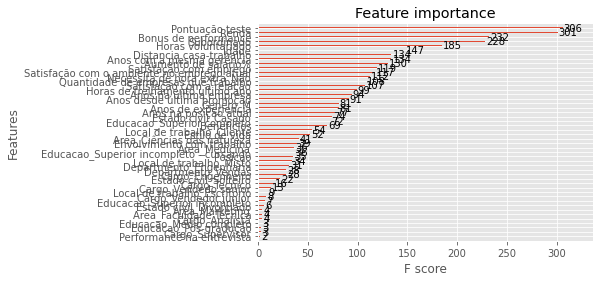

In [26]:
xgb.plot_importance(xgb_model)